## Bayesian approach

#### Frequentist concerns

- Test power concerns: influenced by threshold, data variance, sample size
- No peeking allowed! The test needs to be run as whole
- P-value can fluctuate as number of samples inceases

#### Ethical dilemma
- Observe that drug is working - should we provide treatment for control group earlier?

#### Bayseian approach

- Adapts as more data comes in
- So no need to worry about ending test early
- Power of tests / sample size / effect size is of no worry
- Shift from reject/ do not reject terminology, confidence interval interpretation
- Instead of rejecting the null hypothesis answer P(A > B)

#### Explore-Exploit dilemma
Casino analogy
Simplification - Win (1) or Lose (0). Two machines to play.
Which machine to play? Hard to tell, since we have no prior knowledge.

I - 0

II - ? 

I - 0 

II - 1 

P(success) = wins/total 

After two trials - P(success I) = 0, P(success II) = 1

These are MLE estimates. Smth wrong?

I - 0 

II - 1, 0

P(success II) = 0.5


I - 0 

II - 1, 0, 0

P(success II) = 1/3

This is `greedy` choice.


I - 0 

II - 1, 0, 0, 0

P(success II) = 1/4

Shall we choose II again?
What can be done against `greedy` search?


##### Statistical peculiarities here
- We should choose how much data to collect before staring the experiment
- Determine the power and effect size. But how is it possible if we didn't play beforehand?
- What if effect size predictions are wrong?
- You still must take experiments to complete

#### Adaptation 
- Use quantitative reasoning and algos to adapt.
   1. Collect more data (exploration)
   2. Select choice with highest winning rate (exploration)
- This is `Explore-Exploit` dilemma

- Epsilon-greedy algorithm
- Optimistic Initial Values
- Upper Confidence Bound 
- Thompson Sampling 

#### Epsilon-greedy algorithm
One of the most practical method for quantitive comparison of things

E.g., two models for measuring density for Reservoir Engineering department. Which one is better?

$ \mu = \bar{x} \pm Z_{\frac{\alpha}{2}} \frac{\sigma}{\sqrt{n}}$

where

$ \bar{x} $ - point estimate, 

$ Z_{\frac{\alpha}{2}} $ - confidence level,

$ \frac{\sigma}{\sqrt{n}}$ - margin of error

- Infinite number of samples to get an absolute precise estimate of a metric
- More samples leads to interval shrinking

BUT! If we execute suboptimal model a lot of times, we waste resources.

- Need to balance explore/exploit
- Choosing best MLE win rate does not work. This is called greedy.
- Shortsighted, no regards to confidence in prediction or amount of data collected

Name `Epsilog-Greedy` comes from modifying the greedy strategy. Idea: have a small probability of 
doing smth random (non-greedy) with probability $\epsilon$ (0.05, 0.1).


- Exploration with $\epsilon \gg 0$ to collect data about all models.
- When do we have enough data? Is is supoptimal forever?
- E.g. $E(R) = (1-\epsilon)*\alpha + \epsilon*\frac{\alpha+\beta}{2}$ 

#### Decaying epsilon
- $\epsilon(t) \propto 1/t $
- $\epsilon(t) =\epsilon_0 \alpha^t $
- $\epsilon(t) =\frac{a}{\log (bt+c)} $
- etc.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta


class Model:
    def __init__(self, probability, init_mean=0):
        self.probability = probability
        self.mean = init_mean
        if init_mean > 0:
             self.sample_size = 1
        else:
             self.sample_size = 0
    
    def execute(self):
        return np.random.uniform(0,1) < self.probability

    def update(self, x):
        self.sample_size += 1
        self.mean = ((self.sample_size - 1)*self.mean + x) / self.sample_size

def experiment(model_probs, eps, total=1000):
    models = [Model(p, init_mean=0) for p in model_probs]
    rewards = np.zeros(total)

    num_times_explored = 0
    num_times_exploited = 0
    num_optimal = 0

    optimal_j = np.argmax([m.probability for m in models])
    print("optimal j:", optimal_j)

    for i in range(total):

      # use epsilon-greedy to select the best
      if np.random.uniform(0,1) < eps:
        num_times_explored += 1
        j = np.random.randint(len(models))
      else:
        num_times_exploited += 1
        j = np.argmax([m.mean for m in models])

      if j == optimal_j:
        num_optimal += 1

      # execute best model
      x = models[j].execute()

      # update rewards 
      rewards[i] = x

      # update the distribution for the executed model
      models[j].update(x)
      
    for m in models:
      print("mean estimate:", m.mean)

    # print total reward
    print("total reward earned:", rewards.sum())
    print("overall win rate:", rewards.sum() / total)
    print("num_times_explored:", num_times_explored)
    print("num_times_exploited:", num_times_exploited)
    print("num times selected optimal bandit:", num_optimal)

    # plot the results
    cumulative_rewards = np.cumsum(rewards)
    win_rates = cumulative_rewards / (np.arange(total) + 1)
    plt.plot(win_rates)
    plt.plot(np.ones(total)*np.max(model_probs))
    plt.show()

optimal j: 2
mean estimate: 0.20121951219512196
mean estimate: 0.4864864864864865
mean estimate: 0.7444260941370777
total reward earned: 7317.0
overall win rate: 0.7317
num_times_explored: 473
num_times_exploited: 9527
num times selected optimal bandit: 9688


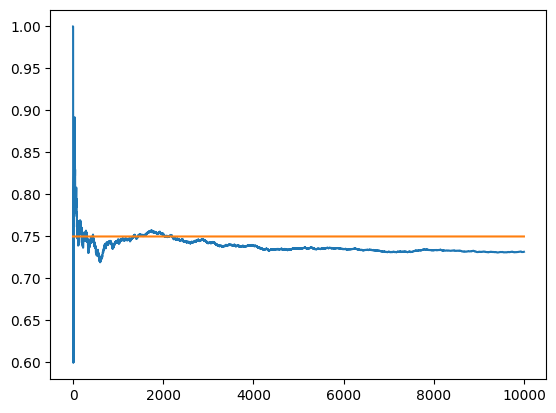

In [2]:
total = 10000
eps = 0.05
model_probs = [0.2, 0.5, 0.75]
experiment(model_probs, eps, total)

### UCB1
Upper Confidence Bound 

1. Epsilong-greedy: small probability of random (uniform) exploration
2. Optimistic - start at large mean value and goto true mean
3. UCB

When N gets bigger, more confidence




Can we use the rules of probability to infer the upper bound? 

We will use inequalities:

$ P(\bar{X} - \mu \ge \epsilon) \le f(\epsilon) $
-------------------------------------------------

Markov inequality

$P(\bar{X_n} \ge \epsilon * \mu) \le \frac{1}{\epsilon}$ 
-------------------------------------------------

Hoeffding's inequality (used in UCB1)

$P(\bar{X_n} - \mu \ge \epsilon ) \le e^{-2nt^2}$ 
-------------------------------------------------


$j = \underset{x}{\arg\max} \left( \bar{X_{n_j}} + \sqrt{2\frac{\log N}{n_j}}\right)$

still greedy with respect to upper bound

In [3]:
class BetaModel(Model):
    def __init__(self, probability, init_mean=0):
        super().__init__(probability, init_mean)
        self.alpha = 1
        self.beta = 1
    
    def sample(self):
        return np.random.beta(self.alpha, self.beta)
    
    def update(self, x):
        self.alpha += x
        self.beta += 1 - x
        self.sample_size += 1

def plot(models, trial):
    x = np.linspace(0, 1, 200)
    for m in models:
        y = beta.pdf(x, m.alpha, m.beta)
        plt.plot(x, y, label=f"real p: {m.probability:.4f}, win rate = {m.alpha - 1}/{m.sample_size}")
    plt.title(f"Distributions after {trial} trials")
    plt.legend()
    plt.show()

In [4]:
np.random.seed(2)
NUM_TRIALS = 2000
PROBABILITIES = [0.2, 0.5, 0.75]

def experiment():
    models = [BetaModel(p) for p in PROBABILITIES]

    sample_points = [5,50,100,500,1500]
    rewards = np.zeros(NUM_TRIALS)
    for i in range(NUM_TRIALS):
      # Thompson sampling
      j = np.argmax([m.sample() for m in models])

      # plot the posteriors
      if i in sample_points:
        plot(models, i)

      x = models[j].execute()
      # update rewards
      rewards[i] = x
      # update the distribution 
      models[j].update(x)

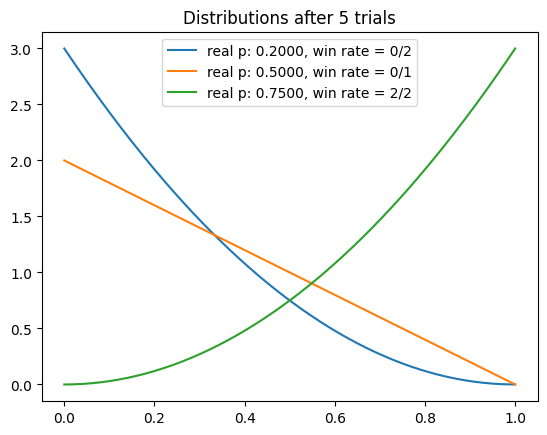

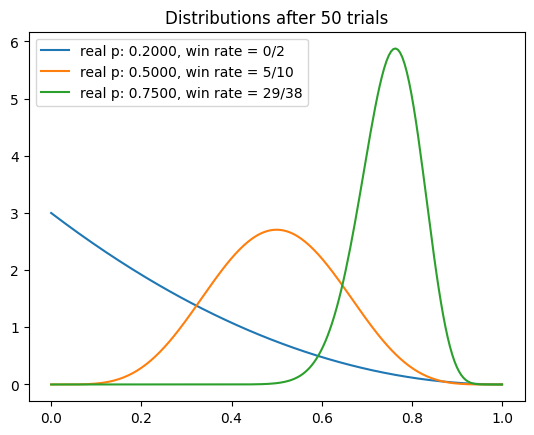

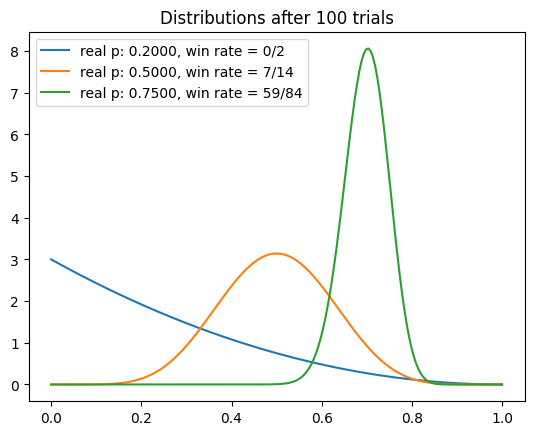

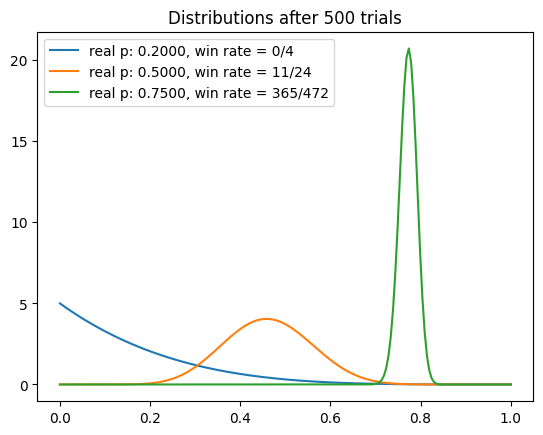

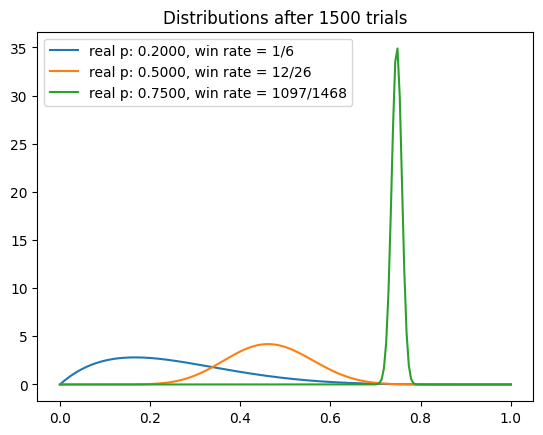

In [5]:
experiment()